In [2]:
# importing the necessary python modules
# numpy and matplotlib are popular packages for scientific computing and plotting
import numpy as np
import matplotlib.pyplot as plt
import pygmsh

# interactive python (iPython) magic to instruct jupyter how to show the plots with respect to the code cells
%matplotlib inline

# scipy is an extension for numpy, used extensively in scientific computing
import scipy as sp

# The following lines are though to import the source functions
import sys
sys.path.append('../src')

# And we import the necessary tools from our source folder.
import MesherWrapper
import MatrixAssembly
import PoroElasticProperties as prop

### Fluid injection in a porous media

We will model the injection of a fluid with a constant rate $Q$ in a wellbore of radius $r_w$ into a porous reservoir of radius $R$.

To do so, we will:

- Create the mesh using ``pygmsh``
  - We will need to specify where we locate *holes* in our mesh
- Impose the boundary conditions
  - There will be a constant flux at the wellbore and no flow at the reservoir boundary
- Compute the temporal evolution of the pressure in the domain
  - The $\theta$ method will be needed here
- Compare the numerical solution to the analytical ones
  - Two different analytical solutions will be employed, making use of different assumptions 

Mesh has 476 nodes


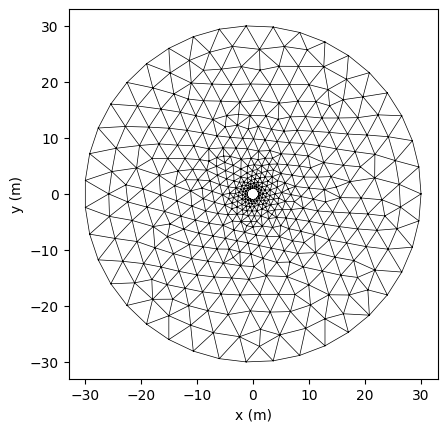

In [3]:
# We will start by defining the mesh

# different radius for the wellbore r and the domain R
r = 1 
R = 30 * r

with pygmsh.geo.Geometry() as geom:

    # we need the outer and inner circles to be defined as curved loops rather than surfaces
    # the make_surface=False keyword is needed
    inner_nodes = geom.add_circle([0, 0], r, mesh_size=0.5, make_surface=False)
    outer_nodes = geom.add_circle([0, 0], R, mesh_size=5, make_surface=False)
    # complete the code below
    # outer_nodes = 

    # we can pass a list of holes to the add_plane_surface function
    surface = geom.add_plane_surface(outer_nodes.curve_loop, holes=[inner_nodes])
    out = geom.generate_mesh()

mesh = MesherWrapper.Mesh(out)

fig, ax= mesh.plot()

# label the axes and the color code
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
print(f'Mesh has {mesh.number_nodes} nodes')


### Boundary conditions

We first start by selecting the nodes located at the wellbore radius $r_w$ and the domain radius $R$. We will use boolean logic as before, but we need to define a small threshold because of the numerical precision.

(-1.5, 1.5)

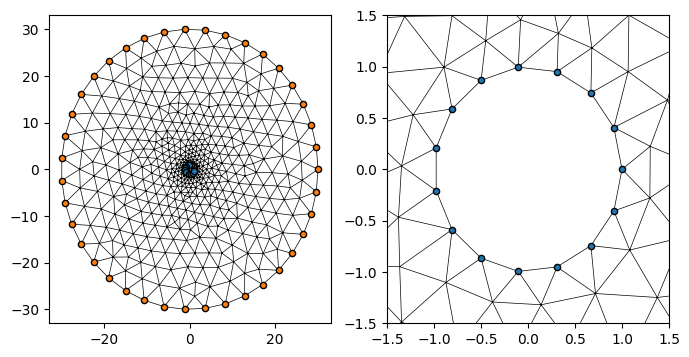

In [4]:
# we need to select the nodes for the two different boundaries to set the proper boundary conditions
eps = 1e-3 # threshold value
# complete the code below
borehole_nodes = np.argwhere(np.abs(np.linalg.norm(mesh.nodes, axis=1) - r) < eps)
outer_nodes = np.argwhere(np.abs(np.linalg.norm(mesh.nodes, axis=1) - R) < eps)


fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    mesh.plot(ax=axs[i])

    axs[i].scatter(*mesh.nodes[borehole_nodes].T, s=20, zorder=10, ec='k')
    axs[i].scatter(*mesh.nodes[outer_nodes].T, s=20, zorder=10, ec='k')

axs[1].set_xlim(-1.5 * r, 1.5 * r)
axs[1].set_ylim(-1.5 * r, 1.5 * r)


Now that we've selected the nodes at the proper boundaries, we can compute the external flux vector. For this, we will integrate the flux $q_e$ at every wellbore segment. Knowing the total flux $Q$, what should be the flux per single element?

In [5]:
# now we want to compute the external flux vector
Q_total = 1
circumference = 2*np.pi*r
# below we compute flux per unit length of wellbore circumference
# complete the code below
q = Q_total/circumference


# we compute the length of a single finite element facet at the wellbore
#complete the code below
segment_length = circumference/len(borehole_nodes)


# we create a vector of external flux and fill it in with the values fluxes integrated at each segment
# Note: external flux is prescribed per node. Each node will get flux from two halves of the segments it belongs to
f = np.zeros(mesh.number_nodes)
# complete the code below
f[borehole_nodes] = q * segment_length


In [6]:
# we proceed to assembly of the conductivity and mass matrices. As you've done this several times, we expect that you know how to do it ;)
perm = [1] # uniform permeability coefficient
C = MatrixAssembly.assemble_conductivity_matrix(mesh, perm)
S = [1] # specific storage
M = MatrixAssembly.assemble_mass_matrix(mesh, S)

### Temporal evolution of the pressure

We will use the $\theta$ method to solve the time-stepping problem. Check out the course notes and the previous exercise.

Step 249 out of 250

Text(0.5, 1.0, 'Pressure (Pa)')

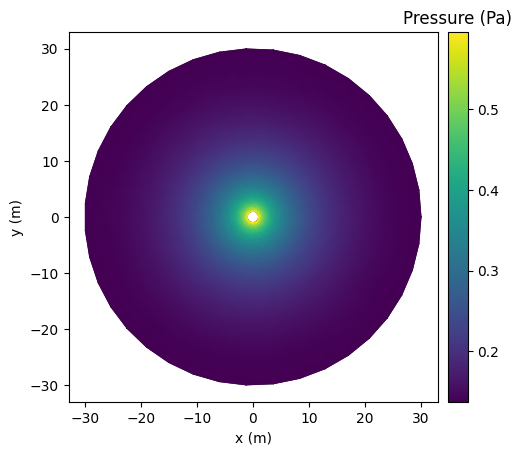

In [7]:
# we can solve the system of equations at every time step
theta = 0.8 # parameter in the time-integration scheme, varies in range [0, 1]

t_final = 500 # final time up to which we run the simulation
dt = 2  # time step
t = np.arange(0, t_final, dt)
pressure = np.zeros((len(t), mesh.number_nodes)) # initial pressure

D =  M + theta * dt * C # matrix combining mass and perm matrices
DInv = sp.sparse.linalg.splu(D) # Prparing its inverse for efficient solving

for i in range(len(t) - 1):
    print(f'\rStep {i + 1} out of {len(t)}', end='')
    # compute the contribution from the previous time step into the right-hand side (rhs)
    # complete the code below:
    rhs = dt * (f - C.dot(pressure[i]))


    # solve for the pressure increment
    # comlete the code below:
    dp = DInv.solve(rhs)


    # update pressure in the current time step
    # complete the code below:
    pressure[i + 1] = pressure[i] + dp

# plotting solution at the final time
fig, ax, cb = mesh.plot(pressure[-1])
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
cb.ax.set_title('Pressure (Pa)')

### Analyzing the results
Now that we have the temporal results, we want to analyze the evolution of the pressure at several points of the domain. From the radial symmetry of the problem, we can look at the pressure for a few points along a radial line.

Actual distances are [ 1.         15.47285996 30.        ]


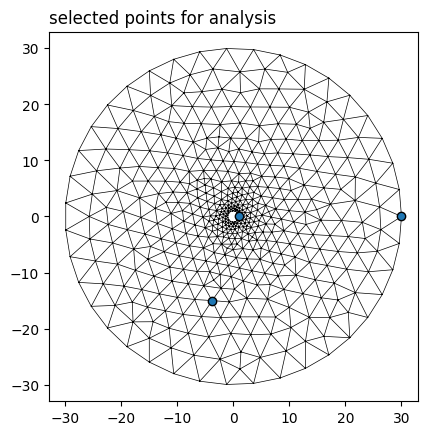

In [8]:
# we want to look at the temporal evoluotion of the pressure for a few given points
radii = [r, (r + R)/2, R]

# since the mesh is not exactly defined at those intervals, we want to take only the closest points
node_indices = np.zeros(len(radii), dtype=int)
for i, radius in enumerate(radii):
    distance_from_radius = np.abs(np.linalg.norm(mesh.nodes, axis=1) - radius)
    # complete the code below
    node_indices[i] = distance_from_radius.argmin()

# we can see which nodes were identified
points = mesh.nodes[node_indices]
mesh.plot()
plt.scatter(*points.T, zorder=10, ec='k')
plt.title('selected points for analysis', loc='left')
radii_actual = np.linalg.norm(points, axis=1)
print(f'Actual distances are {radii_actual}')

### Comparison with analytical solutions

We will compare the numerical results with two analytical solutions:

- Line source in an infinite reservoir:

this one approximates the wellbore as a line source and that the domain is infinite, also known as the *Theis solution* in hydrogeology. When the fluid front reaches the domain boundary, the solution is no longer valid due to the zero flux condition. We can consider this solution as an *early-time* approximation. The solution is

$$ p(r, t) = \frac{Q}{4\pi k}\mathrm{Ei}\left(\frac{r^2}{4ct}\right),$$

where $Q$ is the flux, $k$ is the permeability coefficient, $c=k/S$ where $S$ is the storage coefficient and $\mathrm{Ei}(x)$ is the exponential integral function.

- Cylindrical source in a finite reservoir:

this solution is more realistic and consider a finite size for both the wellbore and the reservoir. In this exercise we will use only the pseudo steady-state part of this analytical solution, then we will call this solution as *pseudo steady-state* solution. 

$$ p(r, t) = \frac{Q}{4\pi k}\left[\frac{2}{R^2_D - 1}\left(\frac{r^2_D}{4} + t_D\right) - \frac{R^2_D \ln(r_D)}{R^2_D - 1} - \frac{3R^4_D - 4R^4_D \ln(r_D)-2R^2_D - 1}{4(R_D^2 - 1)^2} \right],$$

where $R_D=R/r_w$, $r_D = r/r_w$ and $t_D = t/(cr^2_w)$.

In [9]:
from scipy.special import exp1

def line_source(radius, t, Q, k=1, S=1):
    c = k/S
    r2 = radius * radius
    return Q/(4*np.pi*k) * exp1(r2 / (4 * c * t))
    
def cylindrical_source(radius, wellbore_radius, reservoir_radius, t, Q, k=1, S=1):
    Rd = reservoir_radius/wellbore_radius
    rd = radius/wellbore_radius
    c = k/S
    td = t / (c * wellbore_radius * wellbore_radius)

    A = 2 / ((Rd ** 2) - 1) * ((rd ** 2) / 4 + td)
    B = (Rd ** 2) * np.log(rd) / ((Rd ** 2) - 1)
    C_up = (3 * Rd ** 4) - 4 * np.log(Rd) * (Rd ** 4) - 2 * (Rd ** 2) - 1
    C_down = 4 * ((Rd ** 2) - 1)**2

    return Q/(2 * np.pi * k) * (A - B - C_up / C_down)


/var/folders/vp/r307jgfn2dxd42hgg78_ddb00000gn/T/ipykernel_6542/1939889685.py:6: RuntimeWarning: divide by zero encountered in divide
  return Q/(4*np.pi*k) * exp1(r2 / (4 * c * t))


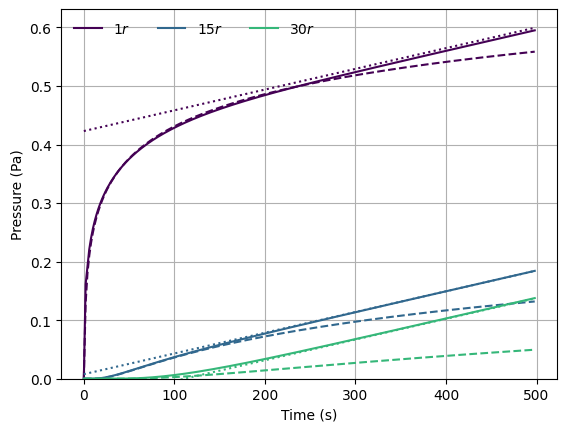

In [9]:
# comparing the numerical and analytical solutions
labels = [f'{radius/r:.0f}$r$' for radius in radii_actual]
cmap = plt.get_cmap('viridis')
colors = [cmap(i/len(labels)) for i in range(len(labels))]

# our pressure array has a shape of n_timesteps x n_nodes
for i, p in enumerate(pressure[:, node_indices].T):
    plt.plot(t, p, label=labels[i], color=colors[i])
    plt.plot(t, line_source(radii_actual[i], t, Q_total), c=colors[i], ls='dashed')
    plt.plot(t, cylindrical_source(radii_actual[i], r, R, t, Q_total), c=colors[i], ls='dotted')

plt.legend(ncol=3, loc='upper left', frameon=False)
plt.xlabel('Time (s)')
plt.ylabel('Pressure (Pa)')
plt.ylim(0, None)
plt.grid()

In [10]:
# as a bonus you get a CG animation of pressure diffusion from the wellbore. Enjoy!
%matplotlib qt

from matplotlib.animation import FuncAnimation

fig = plt.figure()
ax = fig.add_subplot()
im = ax.tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3], pressure[0], shading='gouraud', vmin=pressure.min(), vmax=pressure.max())
plt.colorbar(im)
mesh.plot(ax=ax, c='gray')
ax.set_aspect(1)

time = ax.set_title('t=0')

def update(i):
    time.set_text(f't={t[i]:.2f}')
    im.set_array(pressure[i])
    return im, time

ani = FuncAnimation(fig, update, frames=np.arange(0, len(t), 10), interval=100)
